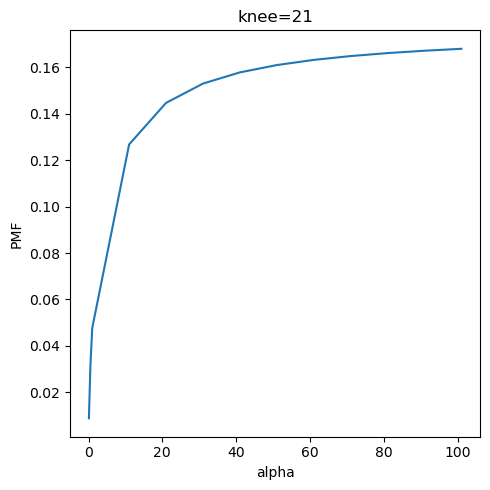

In [2]:
from scipy.stats import dirichlet_multinomial as dm
import pandas as pd
import numpy as np
from kneed import KneeLocator
import matplotlib.pyplot as plt

x = [10, 10]
n = sum(x)
alphas = [0.1, 0.5] + list(range(1, 110, 10))

p = [dm.pmf(x, [a, a], n) for a in alphas]
p = pd.Series(p, alphas)

kneedle = KneeLocator(p.index, p.values, S=1.0, curve='concave', direction='increasing')

fig, ax = plt.subplots(figsize=(5, 5))

p.plot(kind='line', title=f'knee={int(kneedle.knee)}', ylabel='PMF', xlabel='alpha', ax=ax)

fig.tight_layout()

## Example 1

In [13]:
from scipy.stats import dirichlet, multinomial

N = 10_000
alpha = [8, 2]

_d = dirichlet.rvs(alpha, size=N)
_m = (multinomial.rvs(1, p) for p in _d)

df = pd.DataFrame(_m, columns=[f'v{i}' for i in range(len(alpha))])
df

,v0,v1
0,0,1
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
9995,0,1
9996,1,0
9997,1,0
9998,1,0


In [14]:
x = (df.sum() / df.shape[0]).values
x

array([0.8004, 0.1996])

In [16]:
from numpy.random import gumbel

U = pd.DataFrame([(x, gumbel(0, 1, x.shape)) for _ in range(10_000)], columns=['p', 'g']) \
    .assign(z=lambda d: d['p'] + d['g']) \
    .assign(j=lambda d: d['z'].apply(np.argmax)) \
    .assign(r=lambda d: (d['j'] != 0).astype(int)) \
    .query('r == 0') \
    .assign(z_0=lambda d: d['z'].apply(lambda v: v[0])) \
    .assign(z_1=lambda d: d['z'].apply(lambda v: v[1]))[['z_0', 'z_1']] \
    .describe().loc[['mean', 'std']]

U

,z_0,z_1
mean,1.841371,0.229613
std,1.302247,0.852186


In [17]:
U.loc['mean'] - 0.57721

z_0    1.264161
z_1   -0.347597
Name: mean, dtype: float64

## Example 2

In [18]:
N = 10_000
alpha = [5, 3, 2]

_d = dirichlet.rvs(alpha, size=N)
_m = (multinomial.rvs(1, p) for p in _d)

df = pd.DataFrame(_m, columns=[f'v{i}' for i in range(len(alpha))])
df

,v0,v1,v2
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
9995,0,1,0
9996,1,0,0
9997,1,0,0
9998,0,0,1


In [19]:
x = (df.sum() / df.shape[0]).values
x

array([0.503 , 0.3036, 0.1934])

In [61]:
U = pd.DataFrame([(x, gumbel(0, 1, x.shape)) for _ in range(10_000)], columns=['p', 'g']) \
    .assign(z=lambda d: d['p'] + d['g']) \
    .assign(j=lambda d: d['z'].apply(np.argmax)) \
    .assign(
        k_0=lambda d: (d['j'] == 0).astype(int),
        k_1=lambda d: (d['j'] == 1).astype(int),
        k_2=lambda d: (d['j'] == 2).astype(int)
    ) \
    .assign(
        z_0=lambda d: d['z'].apply(lambda v: v[0]),
        z_1=lambda d: d['z'].apply(lambda v: v[1]),
        z_2=lambda d: d['z'].apply(lambda v: v[2])
    ) \
    .assign(
        z_0=lambda d: np.select([d['k_0']==1], [d['z_0'] * d['k_0']], np.nan),
        z_1=lambda d: np.select([d['k_1']==1], [d['z_1'] * d['k_1']], np.nan),
        z_2=lambda d: np.select([d['k_2']==1], [d['z_2'] * d['k_2']], np.nan),
    )[['j', 'k_0', 'k_1', 'k_2', 'z_0', 'z_1', 'z_2']]

U

,j,k_0,k_1,k_2,z_0,z_1,z_2
0,0,1,0,0,0.890337,NaN,NaN
1,0,1,0,0,2.713561,NaN,NaN
2,2,0,0,1,NaN,NaN,0.315806
3,1,0,1,0,NaN,2.398031,NaN
4,1,0,1,0,NaN,0.693204,NaN
...,...,...,...,...,...,...,...
9995,1,0,1,0,NaN,2.385641,NaN
9996,1,0,1,0,NaN,0.757497,NaN
9997,0,1,0,0,0.707251,NaN,NaN
9998,0,1,0,0,2.944565,NaN,NaN


In [62]:
U['j'].value_counts()

j
0    3884
1    3183
2    2933
Name: count, dtype: int64

In [63]:
U[['k_0', 'k_1', 'k_2']].sum()

k_0    3884
k_1    3183
k_2    2933
dtype: int64

In [64]:
U[['z_0']].dropna().mean()  - 0.57721

z_0    1.443863
dtype: float64

In [65]:
U[['z_1']].dropna().mean()  - 0.57721

z_1    1.438467
dtype: float64

In [66]:
U[['z_2']].dropna().mean()  - 0.57721

z_2    1.457983
dtype: float64